In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%load_ext rpy2.ipython

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Import scripts

In [4]:
path_scripts = '/Users/simjoo/Projects/10X_aging/scripts/v3/'

In [5]:
import sys
sys.path.append(path_scripts)

In [6]:
from ipyparallel import Client
import csv
import os
import pickle
import scipy.io
import scanpy as sc
import anndata
import bbknn
import statsmodels.api as sm
import diffxpy.api as de
import scanpy.external as sce
import gseapy as gp

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/numba/core/cpu.py:77: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()


In [7]:
%R library(Seurat)
%R library(SingleCellExperiment)
%R library(scran)
%R library(DESeq2);

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted

In [8]:
from TenX_aging_misc_scripts_v1_0 import *
from TenX_aging_plot_v1_0 import *
from TenX_aging_mann_whitney_u_v1_0 import *

In [9]:
#exp_id = create_ID()

In [10]:
exp_id = '202111251525'
path_input = '/Users/simjoo/Projects/10X_aging/data_input/'
path_output = '/Users/simjoo/Projects/10X_aging/data_output/v3/'
path_figures = '/Users/simjoo/Projects/10X_aging/figures/v3/'

In [11]:
cmap_tab20 = {str(c) : mpl.colors.rgb2hex(plt.cm.tab20(c/20)) for c in range(20)}
cmap_tissue = {'KP':'#e31a1c', 'KPL':'#1f78b4', 'KPLR':'#ff7f00', 'KPR':'#6a3d9a', 'KPT':'#e7298a', 'healthy':'#33a02c'}
cmap_age = {'young': '#377eb8', 'aged': '#e41a1c'}
cmap_tumor_age = {'KP_young':'#fb9a99','KP_aged':'#e31a1c',
                  'KPL_young':'#a6cee3','KPL_aged':'#1f78b4',
                  'KPLR_young':'#fdbf6f','KPLR_aged':'#ff7f00',
                  'KPR_young':'#cab2d6','KPR_aged':'#6a3d9a',
                  'KPT_young':'#e78ac3','KPT_aged':'#e7298a',
                  'healthy_young':'#b2df8a','healthy_aged':'#33a02c'}
cmap_tumor_stage = {'healthy':'#33a02c',
                    '4wk':'#1f78b4',
                    '12wk':'#6a3d9a',
                    '17-18wk':'#ff7f00',
                    '19-20wk':'#e31a1c',}
cmap_epithelial_tumor = {'AT2-like': '#b2df8a',
                         'High plasticity state': '#a50f15',
                         'Hopx+ intermediate': '#fb6a4a',
                         'Ribosome high': '#c51b7d',
                         'Endoderm-like': '#542788',
                         'AT2': '#33a02c',
                         'AT1': '#e6ab02',
                         'Ciliated':'#666666'}

# Initialize engines

In [12]:
c = Client()

In [13]:
dview = c[:]

In [14]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/simjoo/Projects/10X_aging/scripts/v3/")')
dview.execute('from TenX_aging_misc_scripts_v1_0 import *')
dview.execute('from TenX_aging_plot_v1_0 import *')
dview.execute('from TenX_aging_mann_whitney_u_v1_0 import *')

<AsyncResult: execute>

# Clustering of all cells

In [12]:
X = sc.read_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

In [13]:
X.X = X.layers['norm_log2']

In [14]:
Xs = X.copy()

## Remove aged KP-RIK cells from 17-18wk timepoint (no young counterpart)

In [15]:
c_sel = Xs.obs[~((Xs.obs['tumor_stage']=='17-18wk')&(Xs.obs['tumor']=='KPR'))].index

In [16]:
len(c_sel)

89731

In [17]:
Xs = Xs[c_sel]

## Remove KP-RIK cells from 19-20wk timepoint

In [19]:
c_sel = Xs.obs[~(Xs.obs['tumor_stage']=='19-20wk')].index

In [20]:
len(c_sel)

76957

In [21]:
Xs = Xs[c_sel]

## Feature selection - gene filtering

In [22]:
g_sel = Xs.var[(Xs.var['mean_counts']>0.1) & (Xs.var['n_cells_by_counts']>(len(Xs.obs_names)*0.1))].index

In [23]:
len(g_sel)

6998

In [24]:
Xs = Xs[:,g_sel]

## Feature selection - VST

In [25]:
pdX = sc2pd(Xs, 'raw')

In [26]:
feat = select_features_vst(pdX, 2500)

In [27]:
Xs = Xs[:,feat]

## Dimensionality reduction - PCA & NMF

In [28]:
pdX = sc2pd(Xs, 'norm_log2')

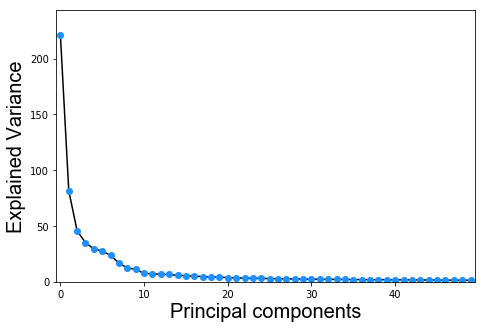

In [29]:
draw_pca_explained_var(pdX)

In [30]:
pca = dim_reduc(pdX, dim=20, method='PCA')
Xs.obsm['X_pca'] = np.array(pca).T 

In [31]:
nmf = dim_reduc(pdX, dim=50, method='NMF')
Xs.obsm['X_nmf'] = np.array(nmf).T 

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [98]:
?? dim_reduc

## UMAP - PCA

In [32]:
bbknn.bbknn(Xs, batch_key='mouse', use_rep='X_pca', neighbors_within_batch=5, metric='euclidean')

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


In [33]:
sc.tl.umap(Xs, min_dist=1, spread=3)

In [34]:
Xs.obsm['X_umap_pca'] = Xs.obsm['X_umap']

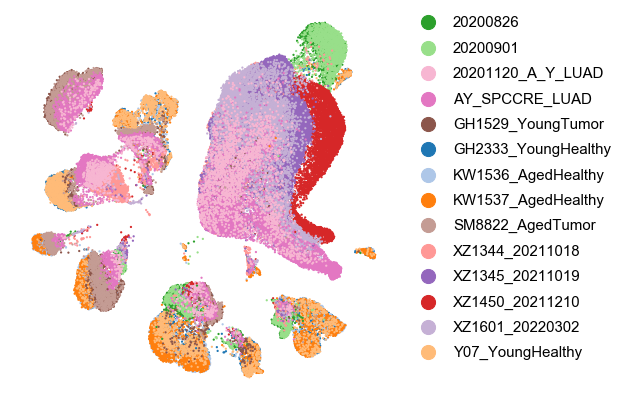

In [35]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['batch'], 
                    s=5, show_axes = False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

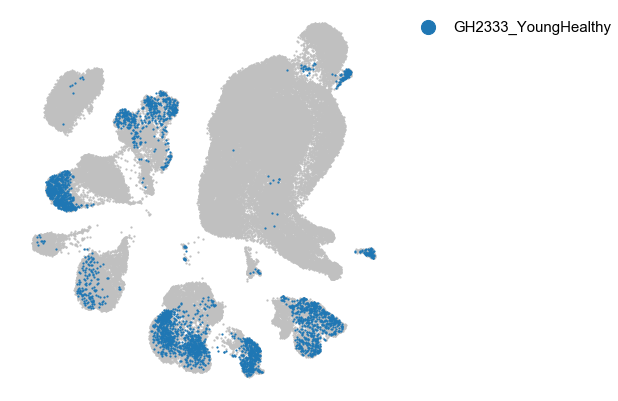

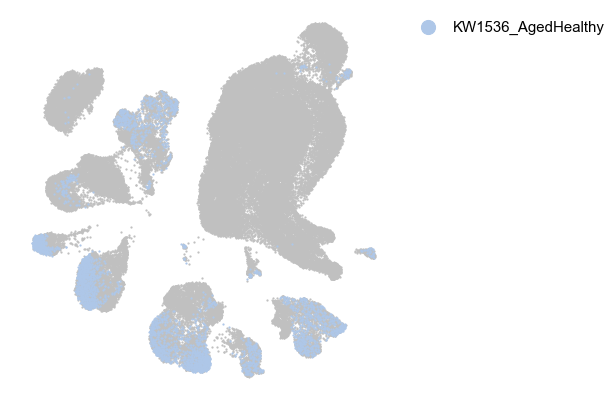

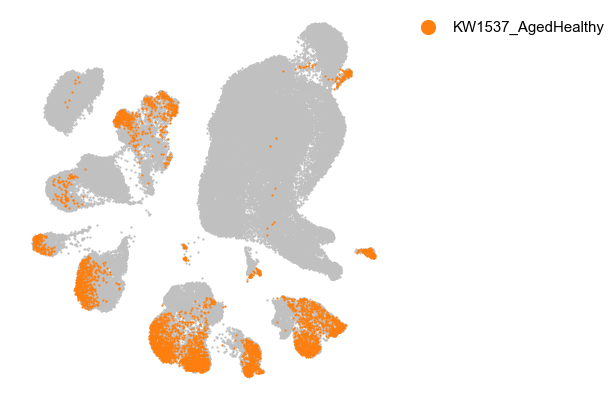

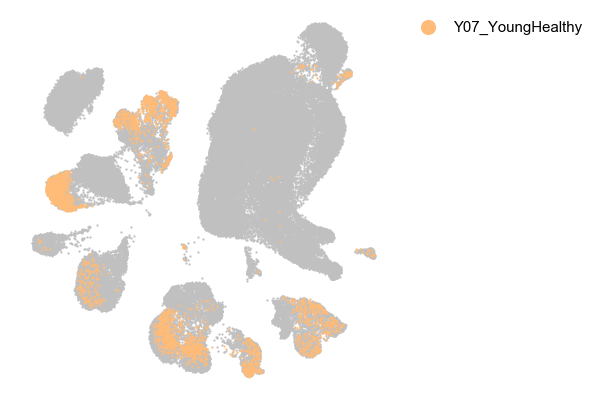

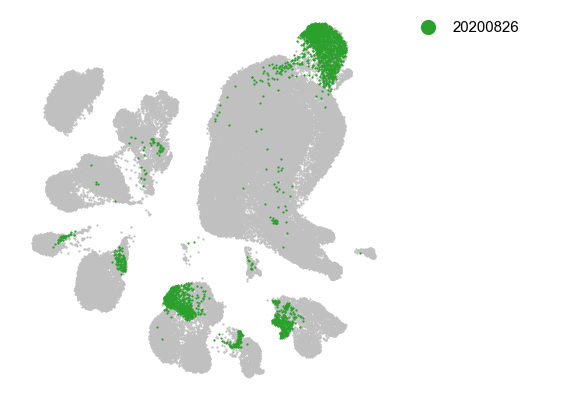

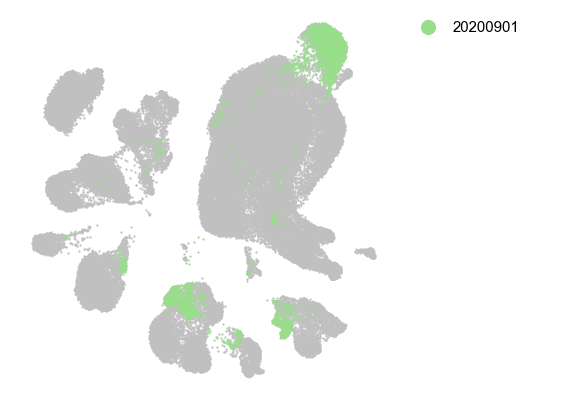

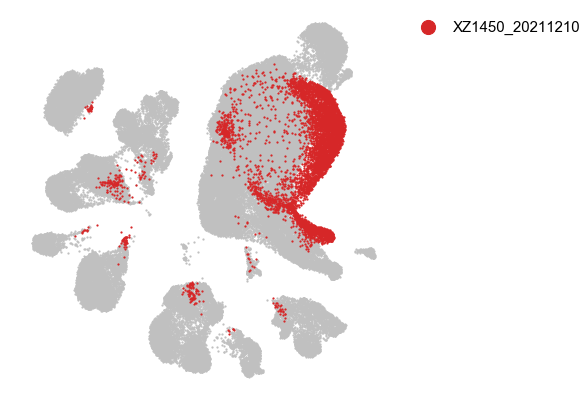

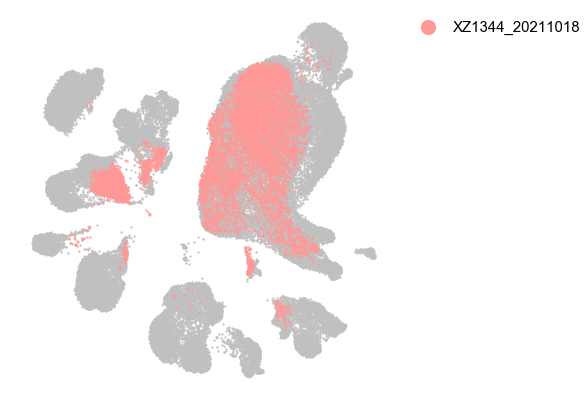

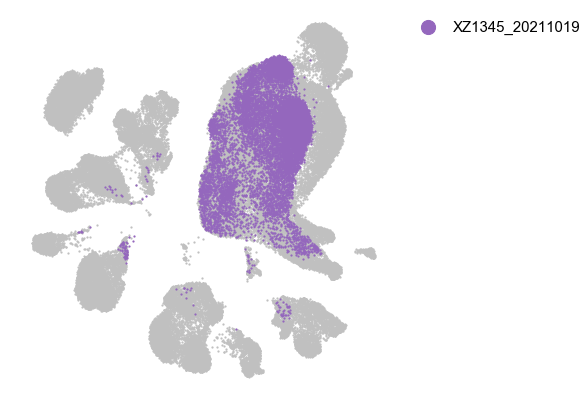

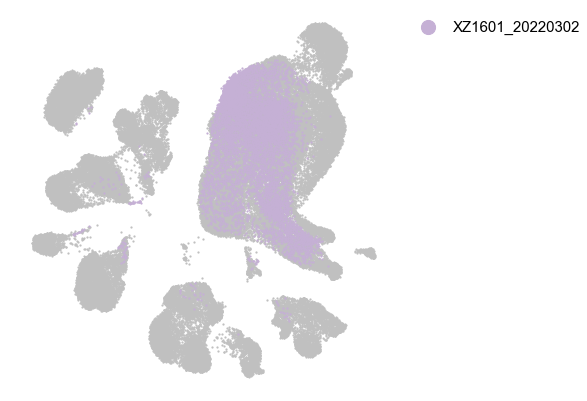

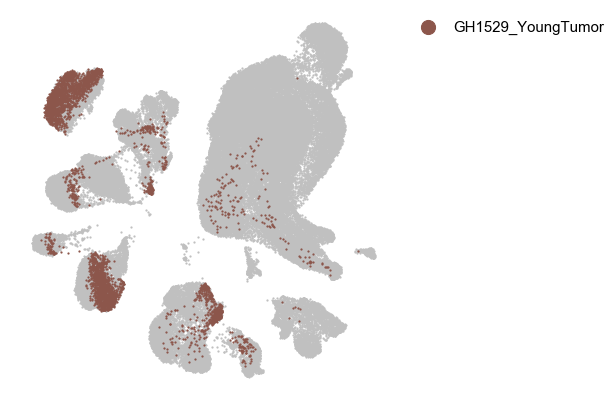

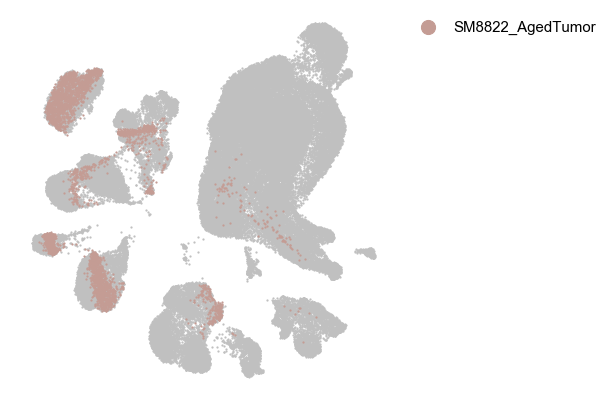

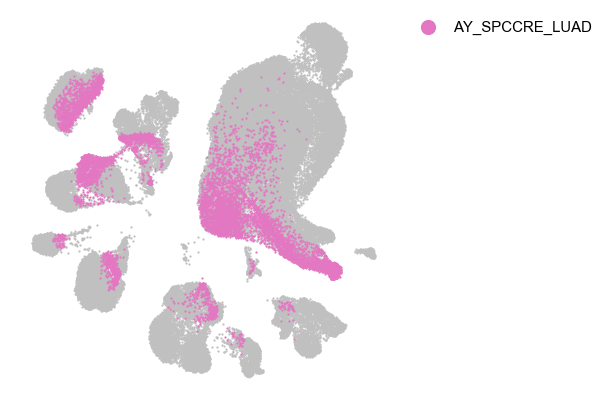

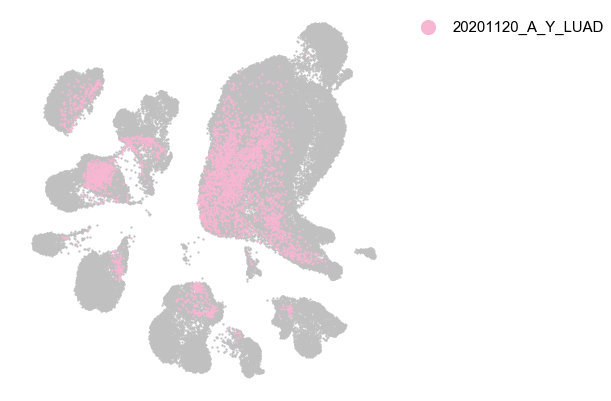

In [36]:
draw_scatter_groups_individual(Xs.obsm['X_umap_pca'], 
                    Xs.obs['batch'], 
                    s=5, show_axes = False)

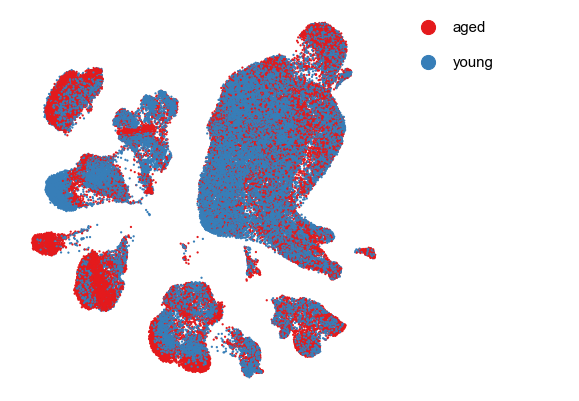

In [37]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['age'],
                    cmap_age,
                    s=5, show_axes = False)

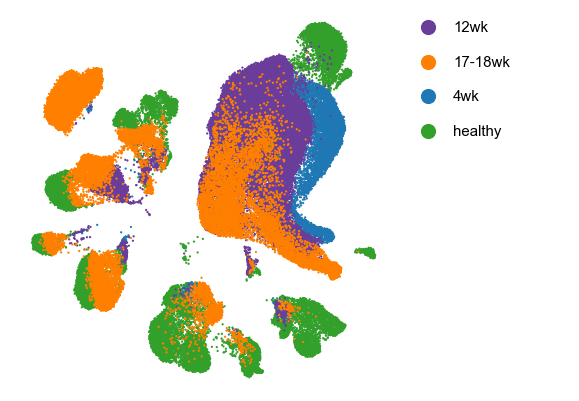

In [54]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['tumor_stage'],
                    cmap_tumor_stage,
                    s=5, show_axes = False)

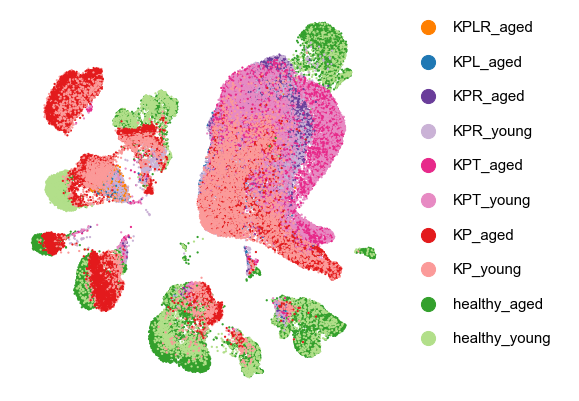

In [38]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['tumor*age'],
                    cmap_tumor_age,
                    s=5, show_axes = False)

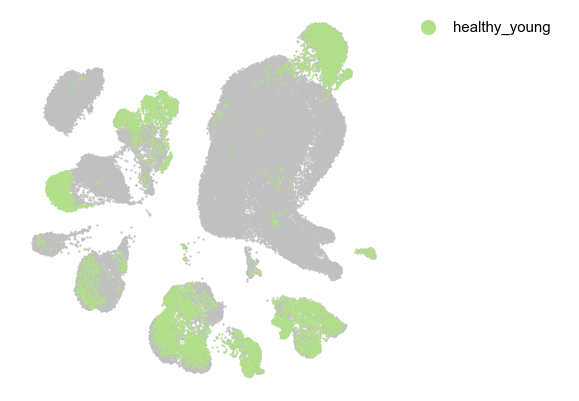

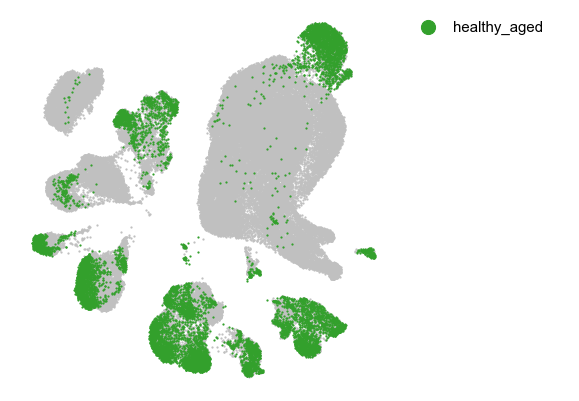

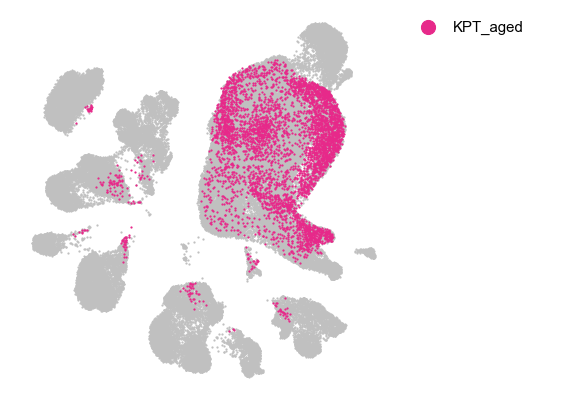

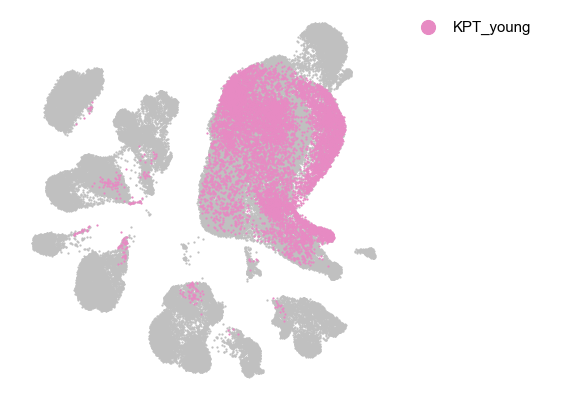

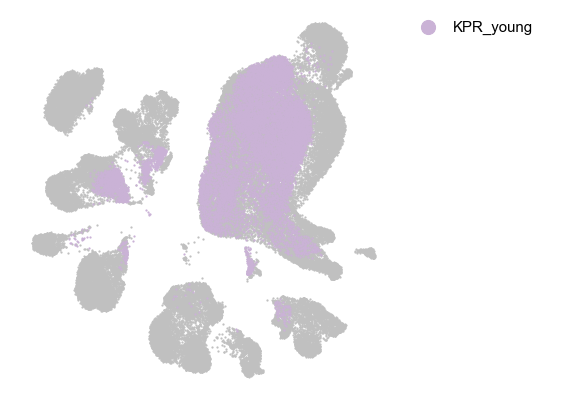

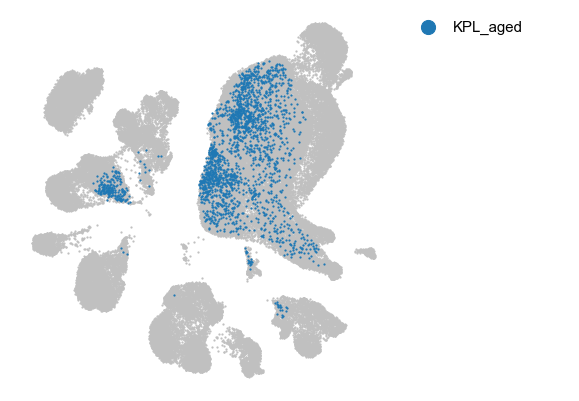

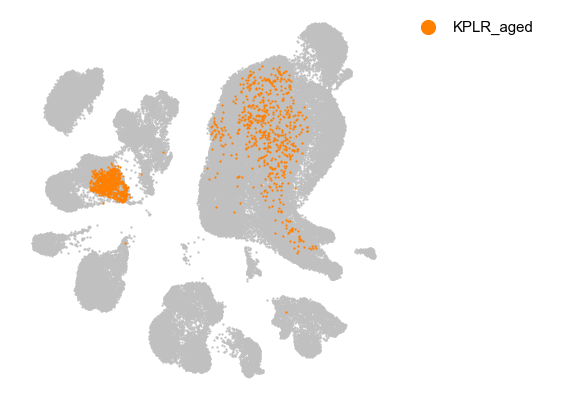

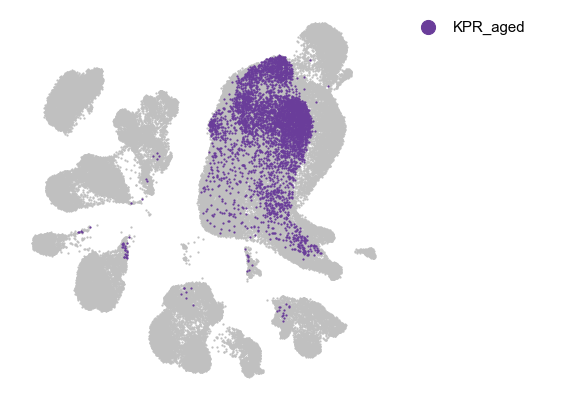

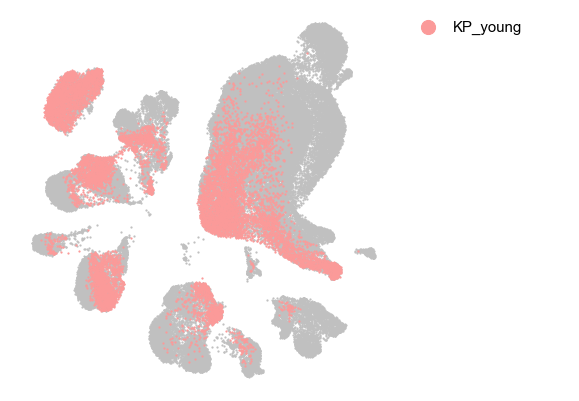

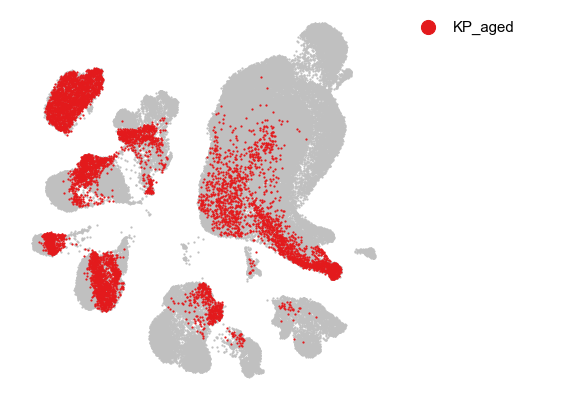

In [39]:
draw_scatter_groups_individual(Xs.obsm['X_umap_pca'], 
                    Xs.obs['tumor*age'], 
                    cmap=cmap_tumor_age,
                    s=5, show_axes = False)

## Marker genes - PCA

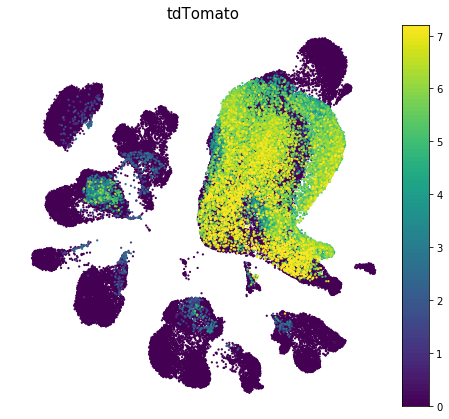

In [40]:
expr = np.log2(Xs.obs['tdTomato']+1)
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = 'tdTomato',
                  s = 5, show_axes=False)

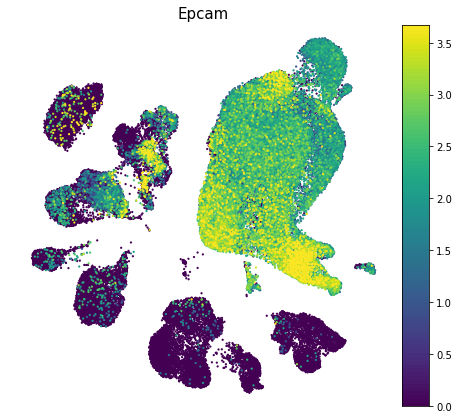

In [41]:
g = 'Epcam'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

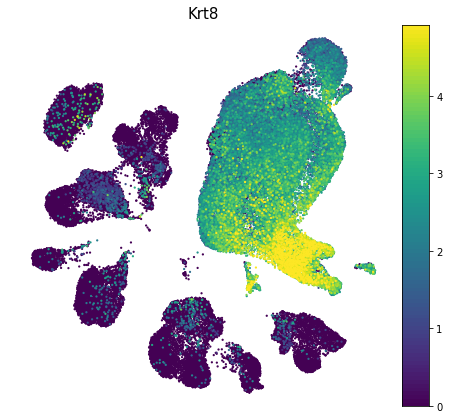

In [42]:
g = 'Krt8'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

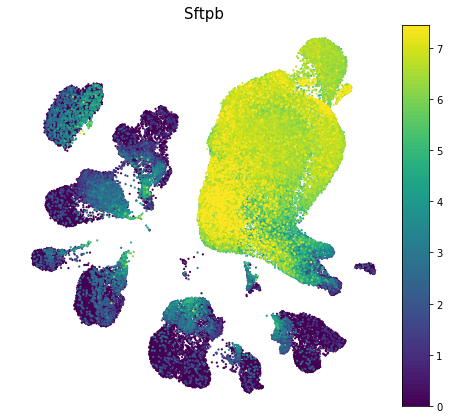

In [43]:
g = 'Sftpb'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

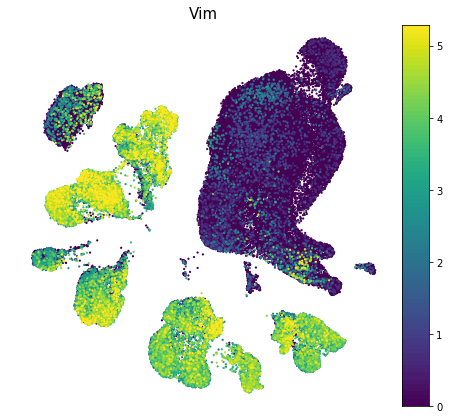

In [44]:
g = 'Vim'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

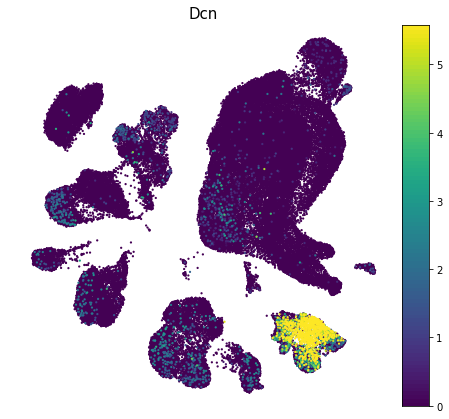

In [45]:
g = 'Dcn'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

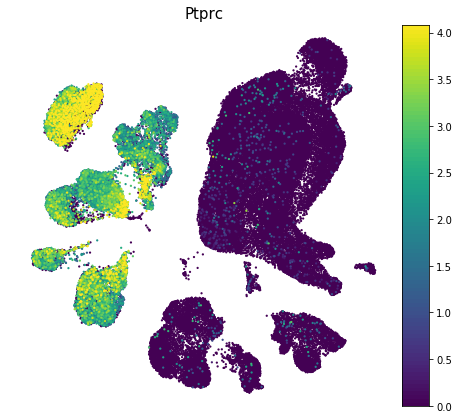

In [46]:
g = 'Ptprc'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

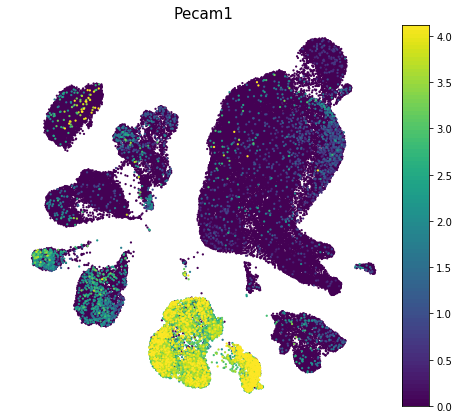

In [47]:
g = 'Pecam1'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

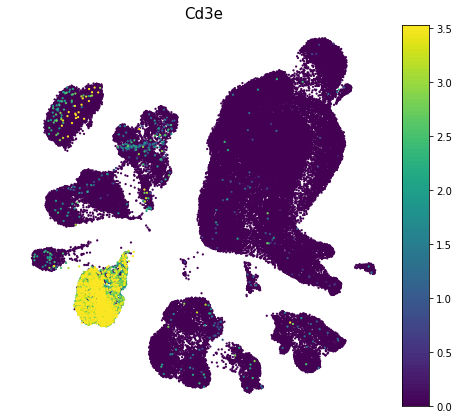

In [48]:
g = 'Cd3e'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

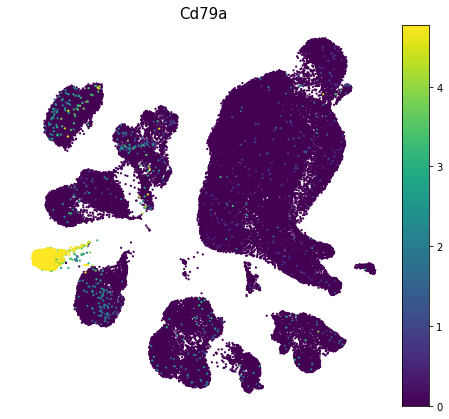

In [49]:
g = 'Cd79a'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

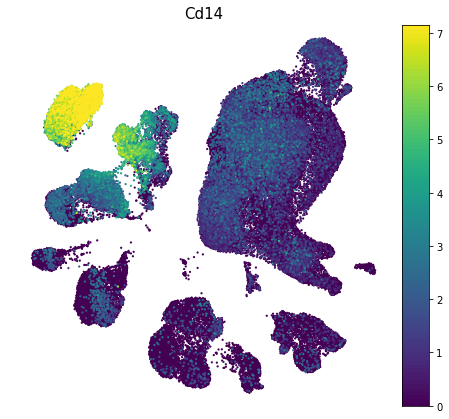

In [50]:
g = 'Cd14'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

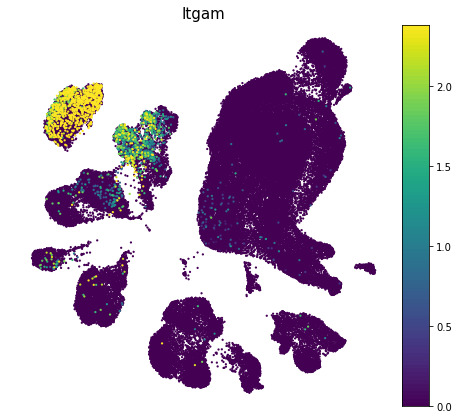

In [51]:
g = 'Itgam'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

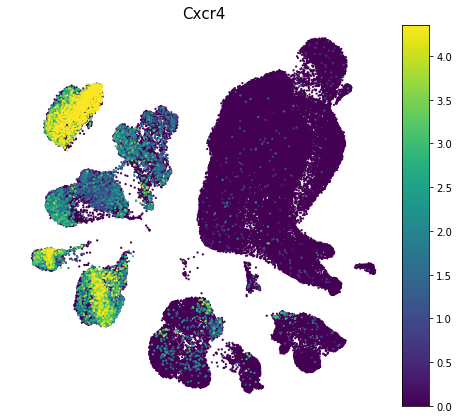

In [52]:
g = 'Cxcr4'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

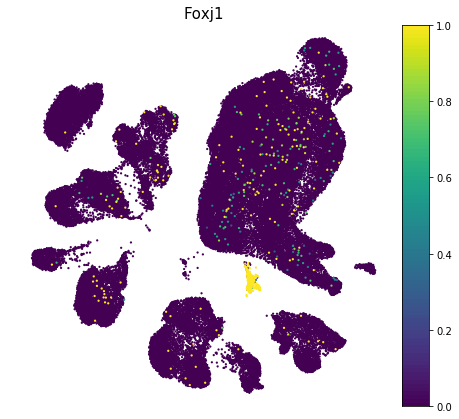

In [53]:
g = 'Foxj1'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

## Leiden clustering - PCA

In [58]:
sc.tl.leiden(Xs, resolution = 0.25)

In [59]:
len(set(Xs.obs['leiden']))

13

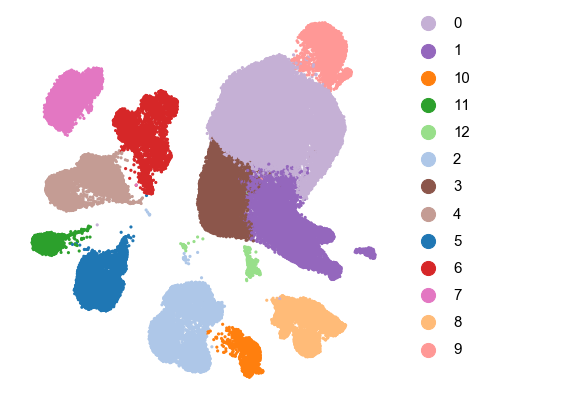

In [60]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['leiden'], 
                    s=10, show_axes=False)

## Wilcoxon-rank sum test - PCA

In [69]:
#pdX_mwu = sc2pd(Xs, 'norm_log2')

In [70]:
#mwu_av_all = mwu_vs_average(pdX_mwu, Xs.obs['leiden'], list(Xs.var_names), dview)
#mwu_gr_all = mwu_vs_groups(pdX_mwu, Xs.obs['leiden'], list(Xs.var_names), dview)

## Assign cluster identities - PCA

In [61]:
cl_all = pd.Series(None, index = Xs.obs_names)

# tumor cells

for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['0','1','3','9','12'])].index:
    cl_all[c] = 'Epithelial cells'
    
# alveolar macrophages
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['4','6'])].index:
    cl_all[c] = 'Macrophages'
    
#T cells
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['5'])].index:
    cl_all[c] = 'T-cells'
    
#B cells
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['11'])].index:
    cl_all[c] = 'B-cells'
    
#Neutrophils
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['7'])].index:
    cl_all[c] = 'Neutrophils'
    
#Fibroblasts
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['8'])].index:
    cl_all[c] = 'Fibroblasts'
    
#Endothelial cells
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['2','10'])].index:
    cl_all[c] = 'Endothelial cells'
    
#Plasmacytoid cells
    
#for c in Xs.obs['leiden'][Xs.obs['leiden'].isin([])].index:
    #cl_all[c] = 'Plasmacytoid cells'

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [62]:
Counter(cl_all)

Counter({'T-cells': 4833,
         'Endothelial cells': 8662,
         'Fibroblasts': 3455,
         'B-cells': 1507,
         'Epithelial cells': 43320,
         'Macrophages': 10582,
         'Neutrophils': 4598})

In [63]:
Xs.obs['cl_all_pca'] = cl_all

In [64]:
cmap_cl_all = {'Macrophages':'#a6cee3',
               'B-cells':'#1f78b4',
               'Endothelial cells':'#33a02c',
               'Epithelial cells':'#e31a1c',
               'Fibroblasts':'#fb9a99',
               'Neutrophils':'#fdbf6f',
               'Plasmacytoid cells':'#ff7f00',
               'T-cells':'#6a3d9a'}

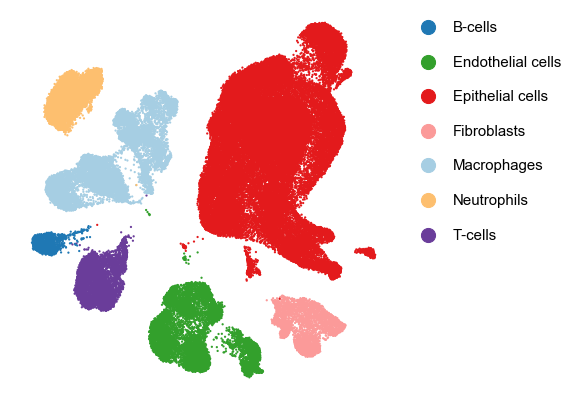

In [65]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['cl_all_pca'],
                    cmap_cl_all,
                    s=5, show_axes=False)

## UMAP - NMF

In [66]:
bbknn.bbknn(Xs, batch_key='mouse', use_rep='X_nmf', neighbors_within_batch=5, metric='euclidean')

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


In [67]:
sc.tl.umap(Xs, min_dist=1, spread=3)

In [68]:
Xs.obsm['X_umap_nmf'] = Xs.obsm['X_umap']

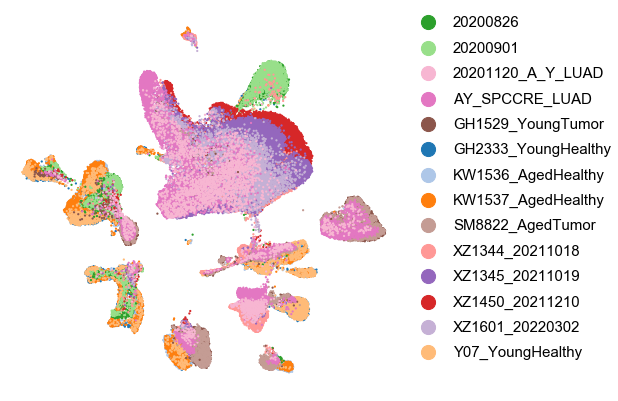

In [69]:
draw_scatter_groups(Xs.obsm['X_umap_nmf'], 
                    Xs.obs['batch'], 
                    s=5, show_axes = False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

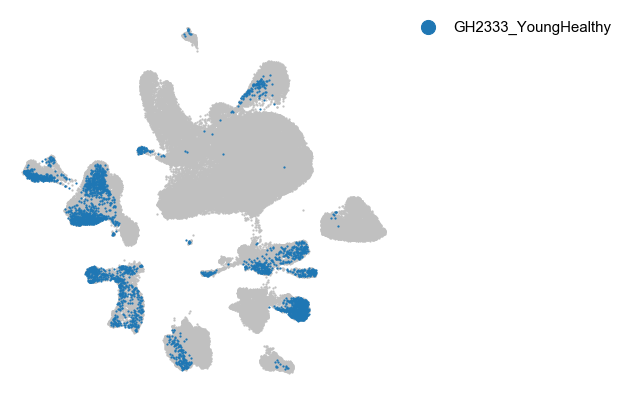

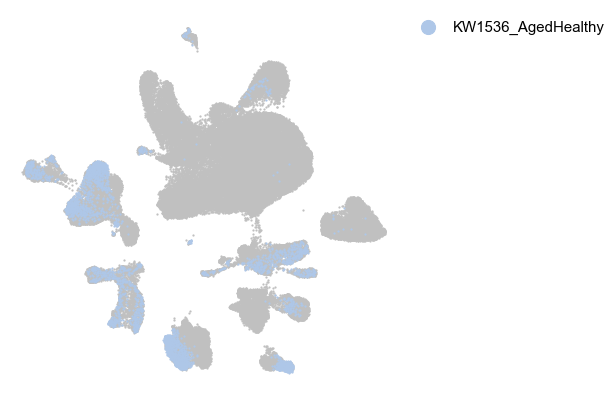

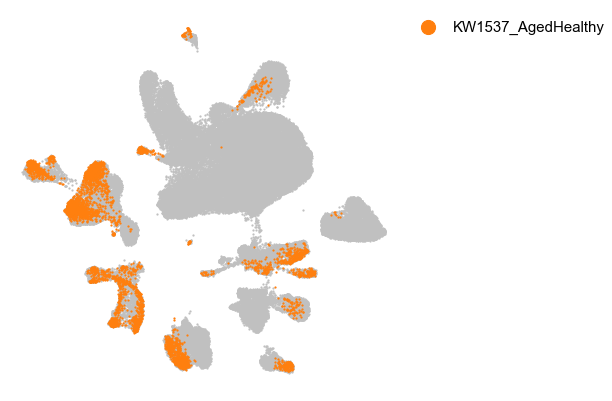

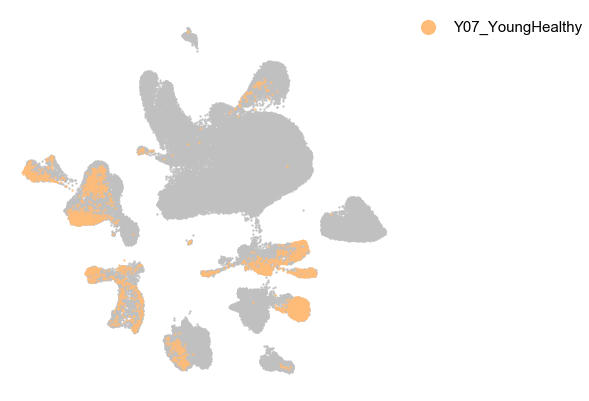

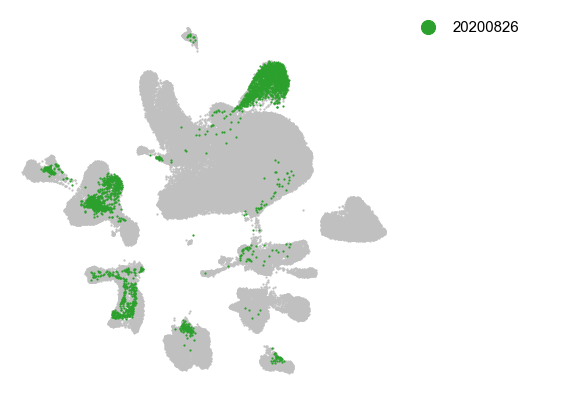

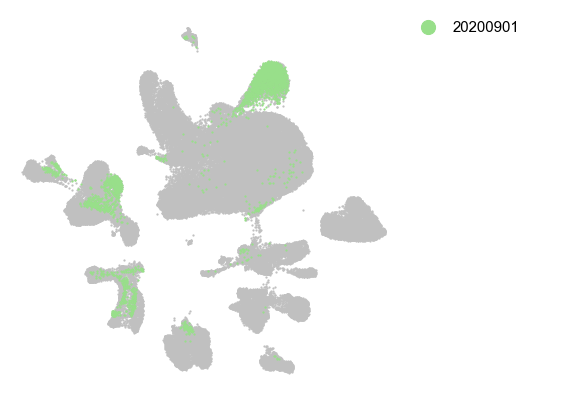

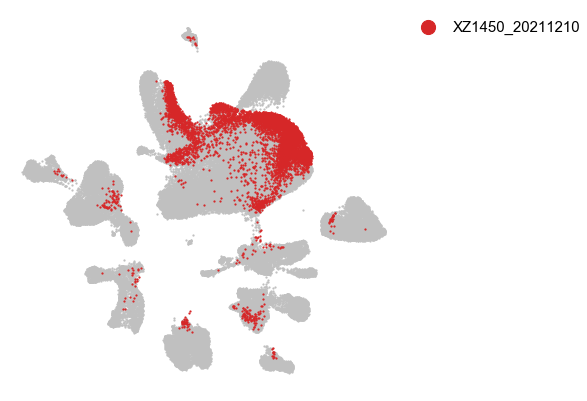

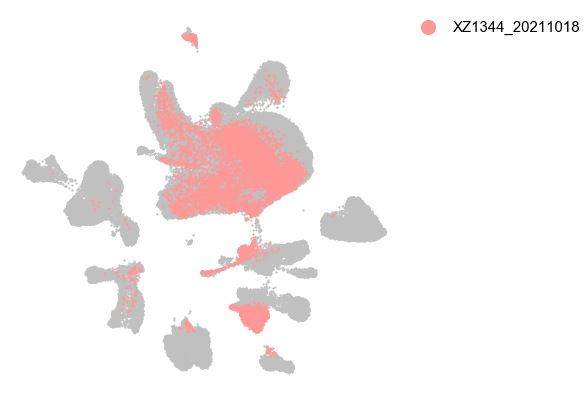

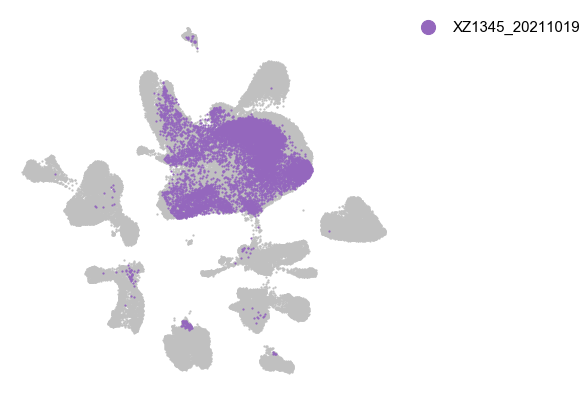

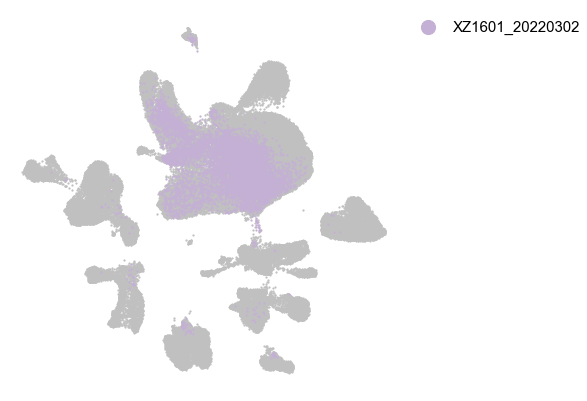

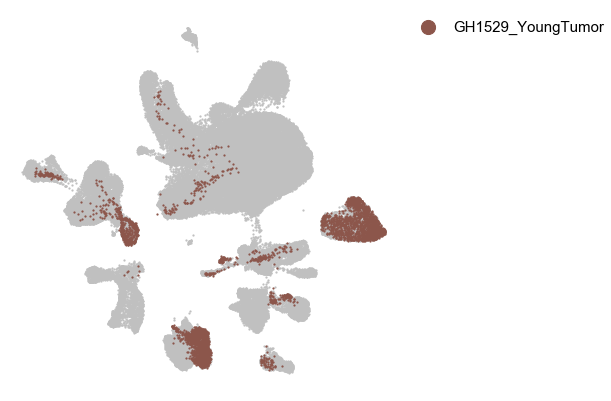

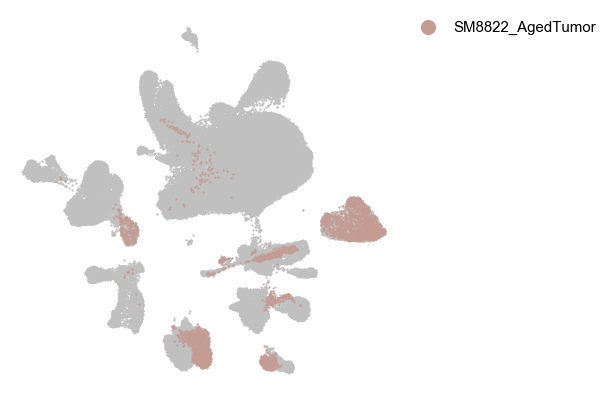

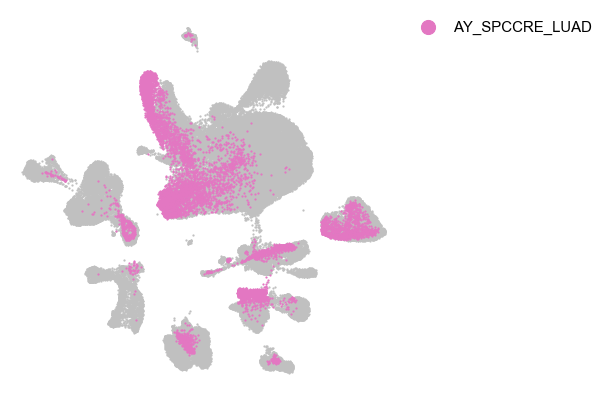

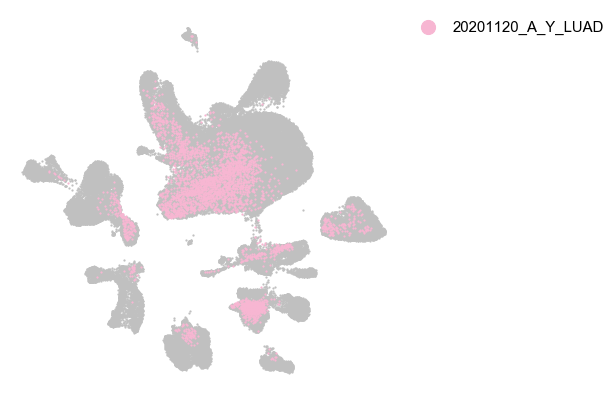

In [70]:
draw_scatter_groups_individual(Xs.obsm['X_umap_nmf'], 
                    Xs.obs['batch'], 
                    s=5, show_axes = False)

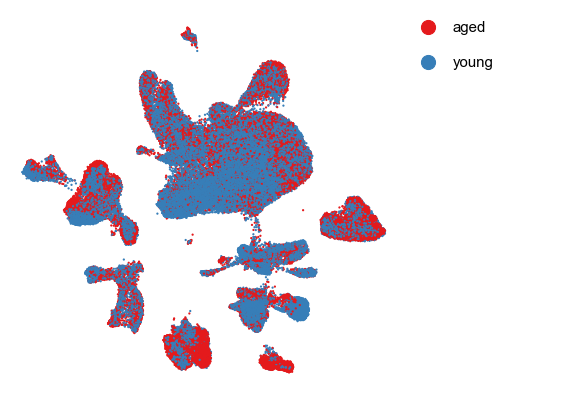

In [71]:
draw_scatter_groups(Xs.obsm['X_umap_nmf'], 
                    Xs.obs['age'],
                    cmap_age,
                    s=5, show_axes = False)

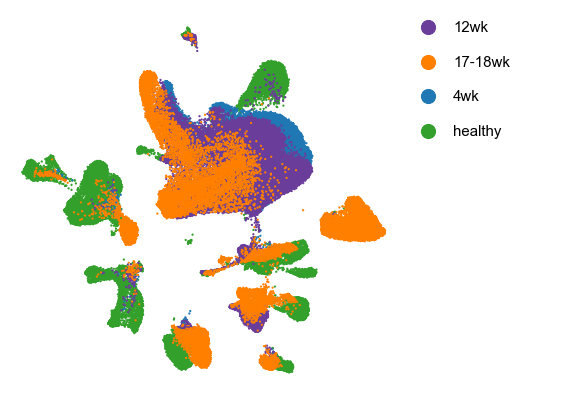

In [72]:
draw_scatter_groups(Xs.obsm['X_umap_nmf'], 
                    Xs.obs['tumor_stage'],
                    cmap_tumor_stage,
                    s=5, show_axes = False)

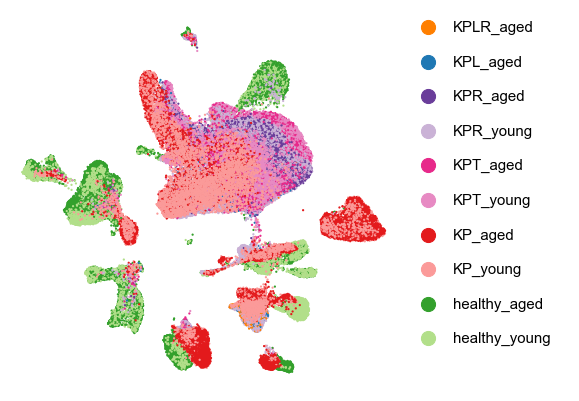

In [73]:
draw_scatter_groups(Xs.obsm['X_umap_nmf'], 
                    Xs.obs['tumor*age'],
                    cmap_tumor_age,
                    s=5, show_axes = False)

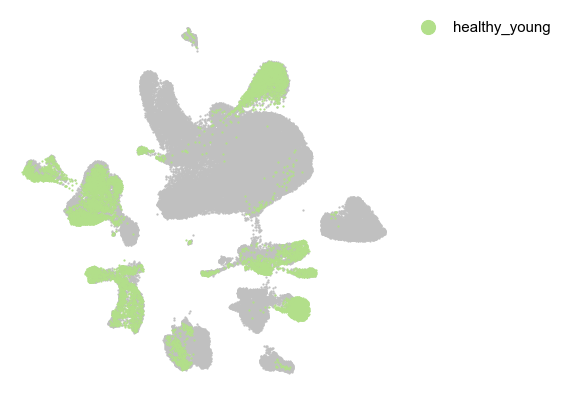

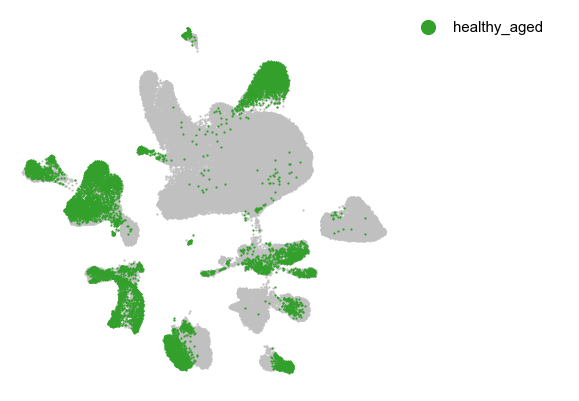

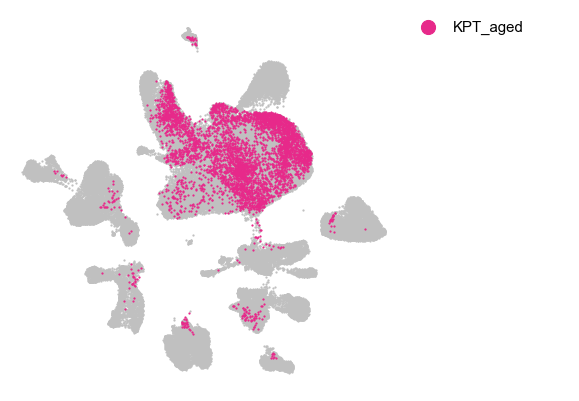

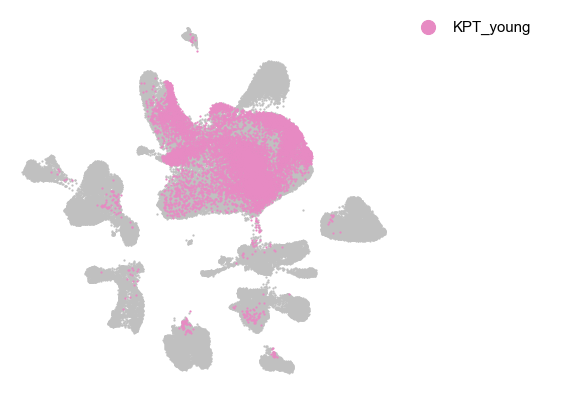

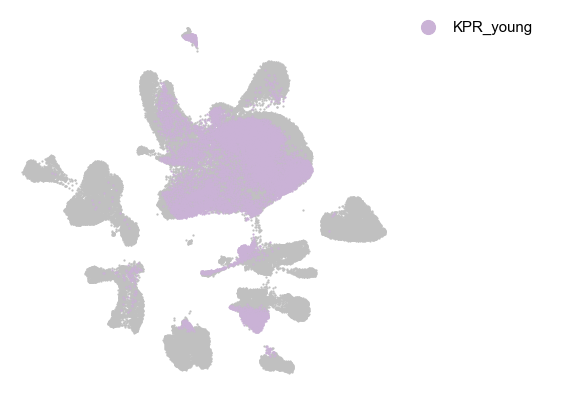

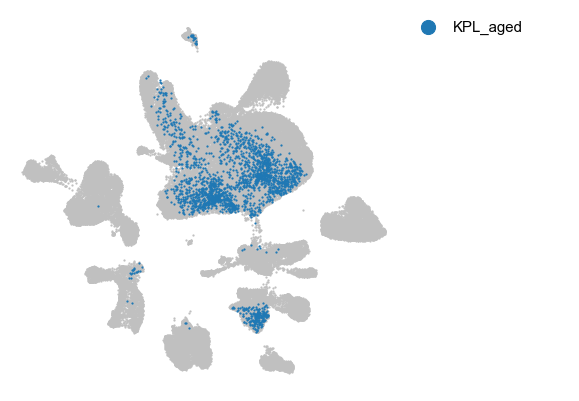

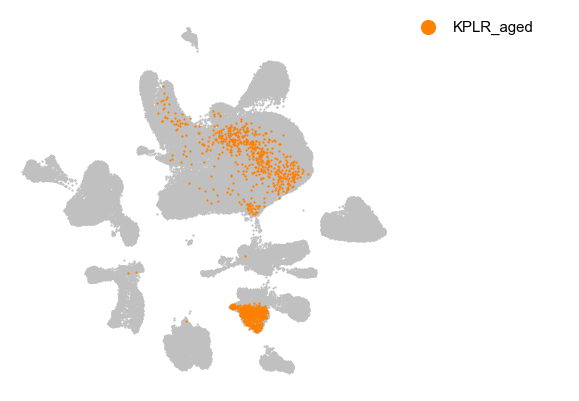

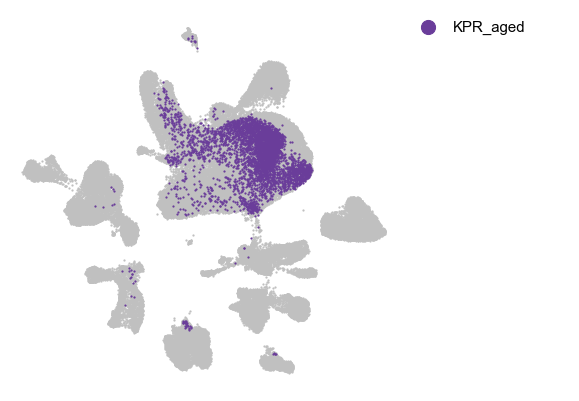

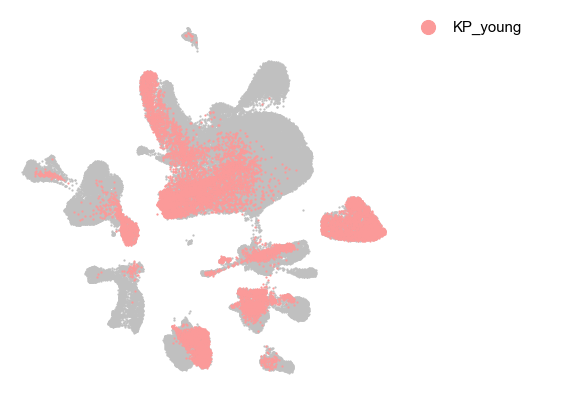

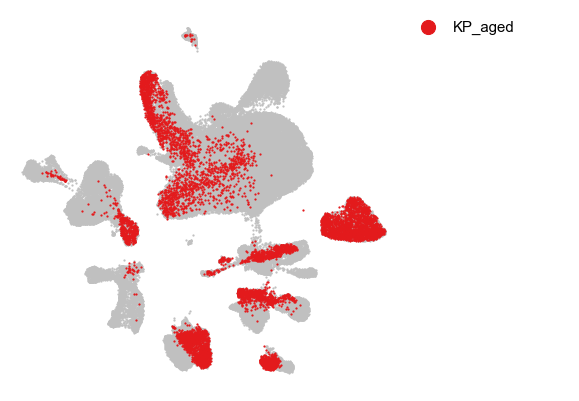

In [74]:
draw_scatter_groups_individual(Xs.obsm['X_umap_nmf'], 
                    Xs.obs['tumor*age'], 
                    cmap=cmap_tumor_age,
                    s=5, show_axes = False)

## Marker genes - NMF

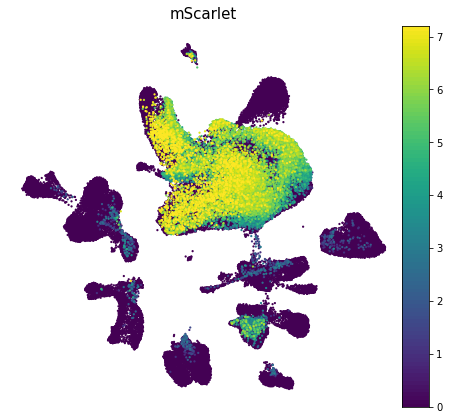

In [75]:
expr = np.log2(Xs.obs['tdTomato']+1)
draw_scatter_expr(Xs.obsm['X_umap_nmf'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = 'mScarlet',
                  s = 5, show_axes=False)

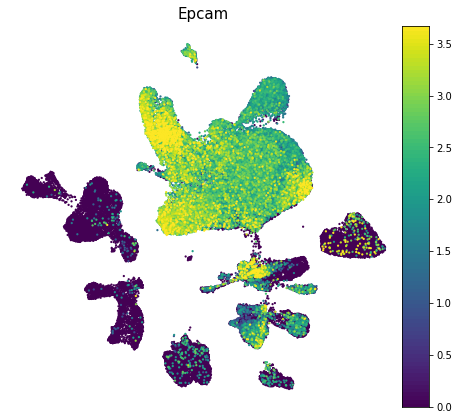

In [76]:
g = 'Epcam'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_nmf'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

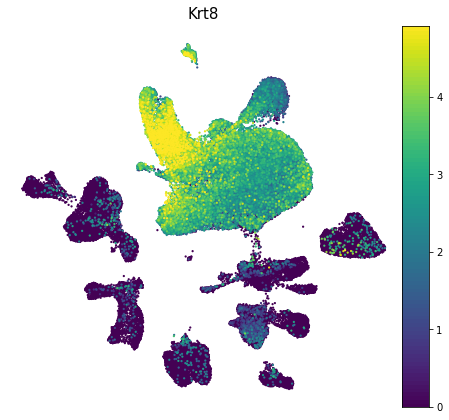

In [77]:
g = 'Krt8'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_nmf'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

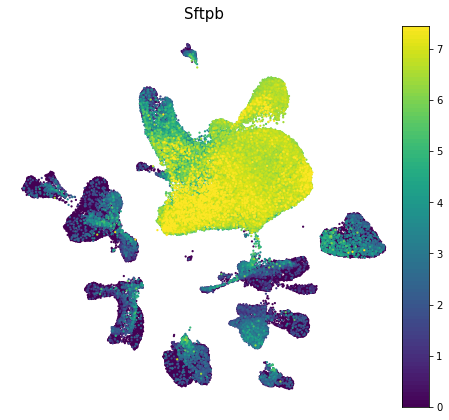

In [78]:
g = 'Sftpb'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_nmf'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

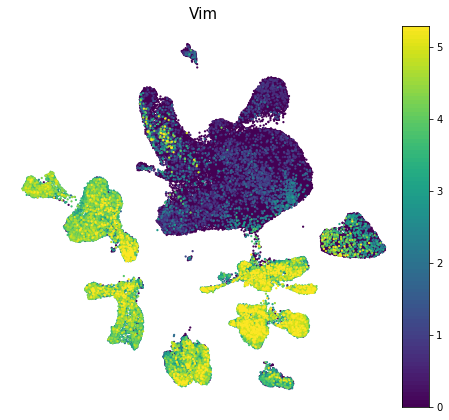

In [79]:
g = 'Vim'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_nmf'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

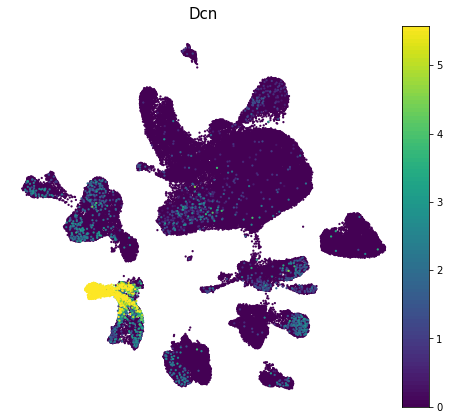

In [80]:
g = 'Dcn'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_nmf'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

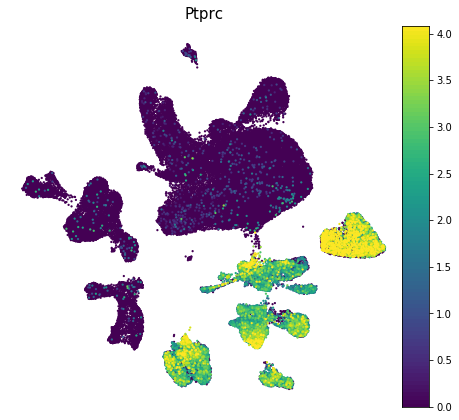

In [81]:
g = 'Ptprc'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_nmf'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

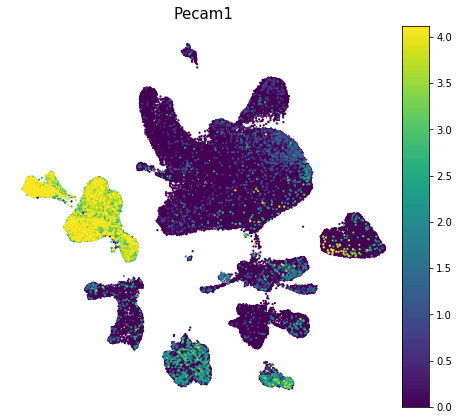

In [82]:
g = 'Pecam1'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_nmf'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

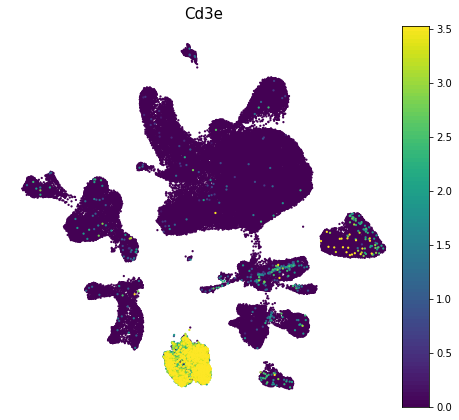

In [83]:
g = 'Cd3e'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_nmf'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

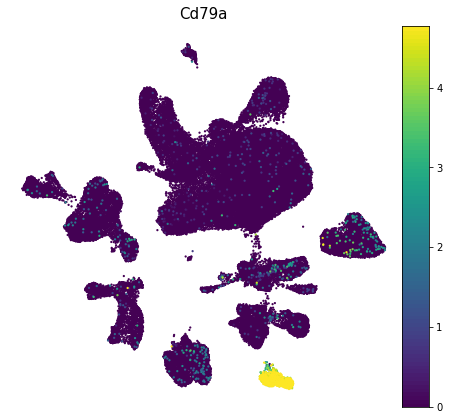

In [84]:
g = 'Cd79a'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_nmf'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

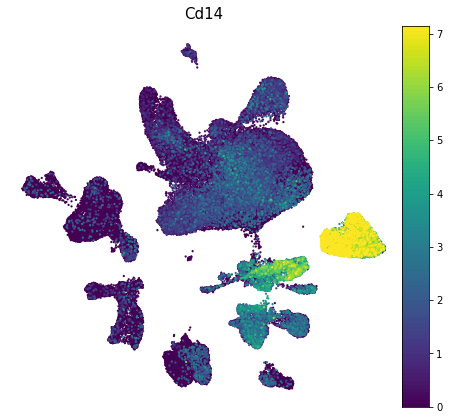

In [85]:
g = 'Cd14'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_nmf'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

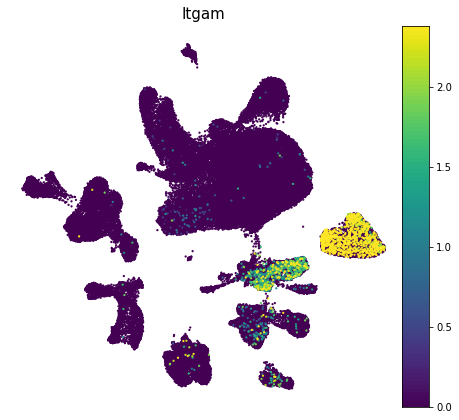

In [86]:
g = 'Itgam'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_nmf'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

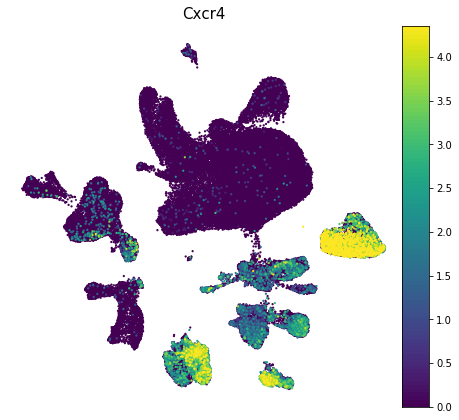

In [87]:
g = 'Cxcr4'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_nmf'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

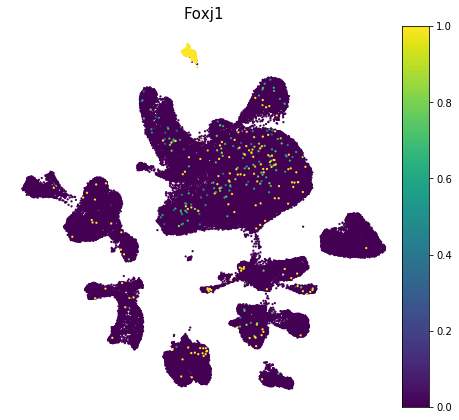

In [88]:
g = 'Foxj1'
expr = sc2pd(X, 'norm_log2').loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_nmf'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

## Leiden clustering - NMF

In [89]:
sc.tl.leiden(Xs, resolution = 0.15)

In [90]:
len(set(Xs.obs['leiden']))

11

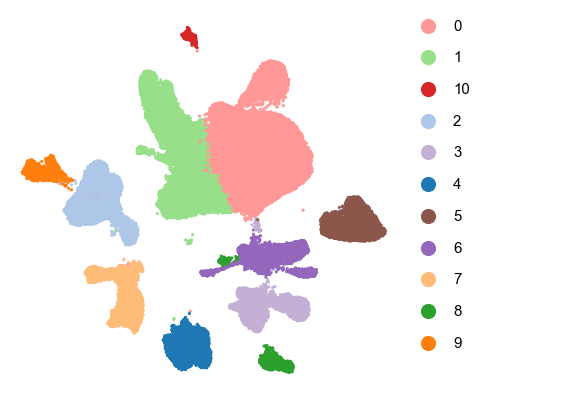

In [91]:
draw_scatter_groups(Xs.obsm['X_umap_nmf'], 
                    Xs.obs['leiden'], 
                    s=10, show_axes=False)

## Wilcoxon-rank sum test - NMF

In [91]:
#pdX_mwu = sc2pd(Xs, 'norm_log2')

In [92]:
#mwu_av_all = mwu_vs_average(pdX_mwu, Xs.obs['leiden'], list(Xs.var_names), dview)
#mwu_gr_all = mwu_vs_groups(pdX_mwu, Xs.obs['leiden'], list(Xs.var_names), dview)

## Assign cluster identities - NMF

In [92]:
cl_all = pd.Series(None, index = Xs.obs_names)

# tumor cells

for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['0','1','10'])].index:
    cl_all[c] = 'Epithelial cells'
    
# alveolar macrophages
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['3','6'])].index:
    cl_all[c] = 'Macrophages'
    
#T cells
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['4'])].index:
    cl_all[c] = 'T-cells'
    
#B cells
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['8'])].index:
    cl_all[c] = 'B-cells'
    
#Neutrophils
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['5'])].index:
    cl_all[c] = 'Neutrophils'
    
#Fibroblasts
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['7'])].index:
    cl_all[c] = 'Fibroblasts'
    
#Endothelial cells
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['2','9'])].index:
    cl_all[c] = 'Endothelial cells'
    
#Plasmacytoid cells
    
#for c in Xs.obs['leiden'][Xs.obs['leiden'].isin([])].index:
    #cl_all[c] = 'Plasmacytoid cells'

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [93]:
Counter(cl_all)

Counter({'T-cells': 4832,
         'Endothelial cells': 8650,
         'Fibroblasts': 3460,
         'B-cells': 1710,
         'Epithelial cells': 43325,
         'Macrophages': 10388,
         'Neutrophils': 4592})

In [94]:
Xs.obs['cl_all_nmf'] = cl_all

In [95]:
cmap_cl_all = {'Macrophages':'#a6cee3',
               'B-cells':'#1f78b4',
               'Endothelial cells':'#33a02c',
               'Epithelial cells':'#e31a1c',
               'Fibroblasts':'#fb9a99',
               'Neutrophils':'#fdbf6f',
               'Plasmacytoid cells':'#ff7f00',
               'T-cells':'#6a3d9a'}

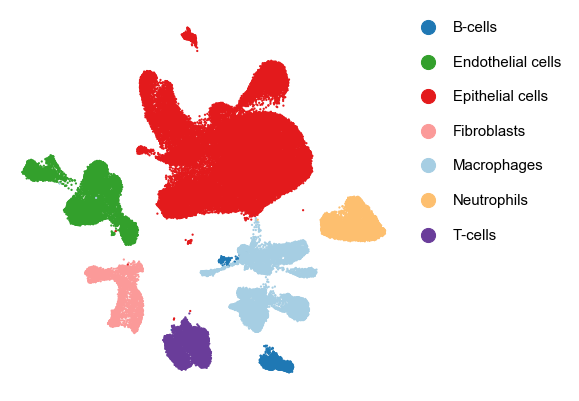

In [96]:
draw_scatter_groups(Xs.obsm['X_umap_nmf'], 
                    Xs.obs['cl_all_nmf'],
                    cmap_cl_all,
                    s=5, show_axes=False)

## Checkpoint

In [97]:
#Xs.write_h5ad('%s/%s_Xs_LUAD_aging_all.h5' % (path_output, exp_id))

... storing 'cl_all_pca' as categorical
... storing 'cl_all_nmf' as categorical
